First finds optimal hyperparameters using Optuna

Then validates model performance using 5-fold cross validation

Finally trains one model on the entire dataset to make future predictions

[I 2024-12-10 18:29:52,310] A new study created in memory with name: no-name-c1832528-762b-4435-8157-9691d40f43c0


Loading data...

Starting hyperparameter optimization...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 5.1967, Val Loss: 10.7896, LR: 0.000003
Epoch 2/100, Train Loss: 5.1800, Val Loss: 10.7678, LR: 0.000005
Epoch 3/100, Train Loss: 5.1567, Val Loss: 10.7350, LR: 0.000006
Epoch 4/100, Train Loss: 5.1097, Val Loss: 10.6913, LR: 0.000008
Epoch 5/100, Train Loss: 5.0497, Val Loss: 10.6364, LR: 0.000009
Epoch 6/100, Train Loss: 5.0094, Val Loss: 10.5701, LR: 0.000011
Epoch 7/100, Train Loss: 4.9315, Val Loss: 10.4919, LR: 0.000012
Epoch 8/100, Train Loss: 4.8681, Val Loss: 10.4012, LR: 0.000014
Epoch 9/100, Train Loss: 4.7399, Val Loss: 10.2971, LR: 0.000015
Epoch 10/100, Train Loss: 4.6201, Val Loss: 10.1783, LR: 0.000015
Epoch 11/100, Train Loss: 4.5048, Val Loss: 10.0584, LR: 0.000014
Epoch 12/100, Train Loss: 4.3877, Val Loss: 9.9428, LR: 0.000012
Epoch 13/100, Train Loss: 4.2999, Val Loss: 9.8372, LR: 0.000010
Epoch 14/100, Train Loss: 4.1774, Val Loss: 9.7462, LR: 0.000008
Epoch 15/100, Train Loss: 4.1084, Val Loss: 9.6733, LR: 0.000006
Epoch 16/100, Train Los

<Figure size 1500x800 with 0 Axes>

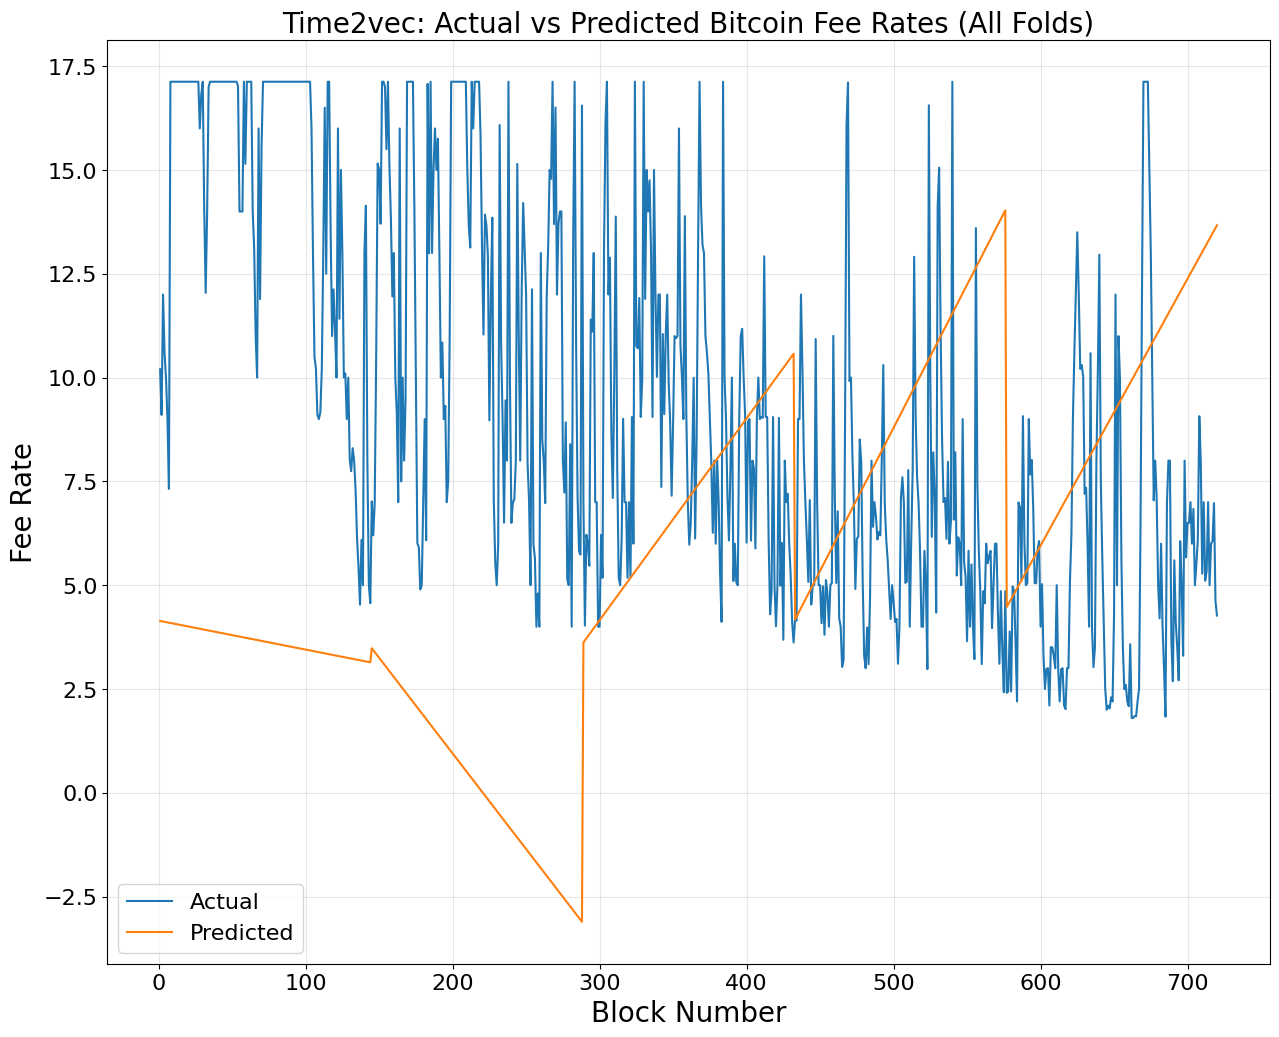


Cross-Validation Results:
Mean Absolute Error (CV): 6.9152 (±3.5053)
Root Mean Squared Error (CV): 7.7091 (±3.3953)
Theil's U Statistic (CV): 0.7001 (±0.0927)
R² Score (CV): -4.0079 (±3.2380)
Directional Accuracy (CV): 41.12% (±6.63%)

Training final model on full dataset...
Epoch 1/100, Train Loss: 5.2009, Val Loss: 8.9536, LR: 0.000003
Epoch 2/100, Train Loss: 5.1813, Val Loss: 8.9316, LR: 0.000004
Epoch 3/100, Train Loss: 5.1551, Val Loss: 8.8987, LR: 0.000006
Epoch 4/100, Train Loss: 5.1200, Val Loss: 8.8552, LR: 0.000007
Epoch 5/100, Train Loss: 5.0697, Val Loss: 8.8067, LR: 0.000009
Epoch 6/100, Train Loss: 5.0185, Val Loss: 8.7592, LR: 0.000010
Epoch 7/100, Train Loss: 4.9680, Val Loss: 8.7048, LR: 0.000011
Epoch 8/100, Train Loss: 4.9005, Val Loss: 8.6296, LR: 0.000013
Epoch 9/100, Train Loss: 4.8153, Val Loss: 8.5377, LR: 0.000014
Epoch 10/100, Train Loss: 4.7226, Val Loss: 8.4406, LR: 0.000014
Epoch 11/100, Train Loss: 4.6240, Val Loss: 8.3491, LR: 0.000013
Epoch 12/100, Tra

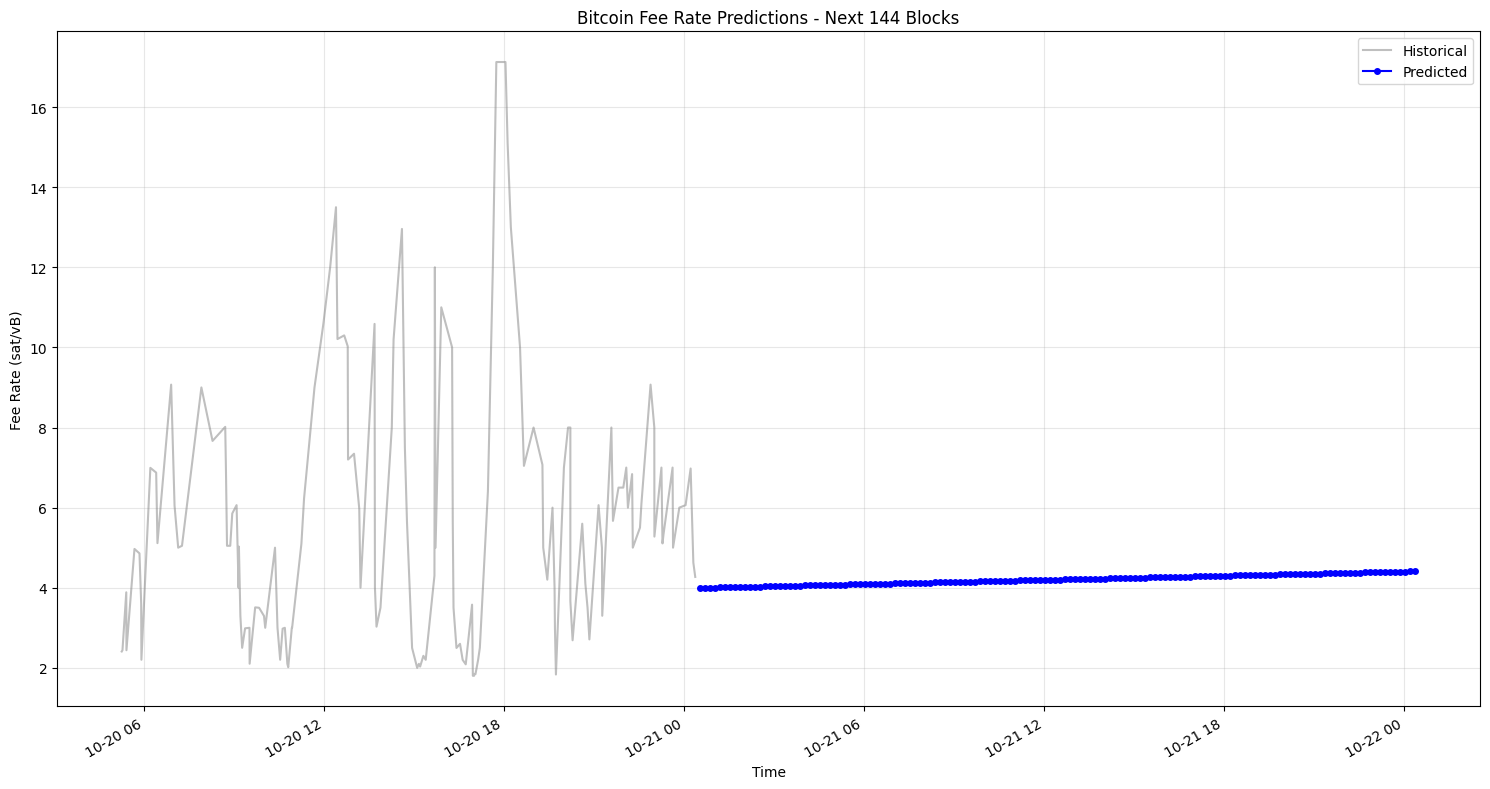


Results saved:
- Predictions: 'time2vec_predictions.csv'
- Best parameters: 'time2vec_best_params.csv'
- Cross-validation results: 'cross_validation_results.csv'


In [3]:
import optuna
from dataclasses import asdict, dataclass
from functools import partial
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import time
import random
import torch.optim.lr_scheduler as lr_scheduler
import warnings

warnings.filterwarnings('ignore')


@dataclass
class ModelConfig:
    """Configuration for LSTM model"""
    time2vec_dim: int = 20
    hidden_dim: int = 128
    batch_size: int = 128
    learning_rate: float = 0.00005
    num_epochs: int = 100
    max_encoder_length: int = 288
    max_prediction_length: int = 144
    clip_grad_norm: float = 1.0
    warmup_epochs: int = 3
    patience: int = 10
    min_delta: float = 1e-4
    dropout: float = 0.1


class EarlyStopping:
    def __init__(self, patience: int = 7, min_delta: float = 1e-4, verbose: bool = True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop


class Time2Vec(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim - 1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim - 1))
        self.f = torch.sin

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)


class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim: int, future_input_dim: int, config: ModelConfig):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, config.time2vec_dim)
        self.lstm = nn.LSTM(
            hist_input_dim + config.time2vec_dim,
            config.hidden_dim,
            batch_first=True,
            dropout=config.dropout
        )
        self.fc_combine = nn.Linear(config.hidden_dim + future_input_dim, config.hidden_dim)
        self.fc_out = nn.Linear(config.hidden_dim, 1)
        self.num_predictions = config.max_prediction_length

    def forward(self, time_feature: torch.Tensor, x_hist: torch.Tensor,
                x_future: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)

        _, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n.squeeze(0)

        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            out = self.fc_out(hidden)
            outputs.append(out)

        return torch.cat(outputs, dim=1)


class Time2VecDataset(Dataset):
    def __init__(self, data: pd.DataFrame, historical_features: List[str],
                 future_known_features: List[str], target: str, config: ModelConfig):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.config = config

    def __len__(self) -> int:
        return len(self.data) - self.config.max_encoder_length - self.config.max_prediction_length + 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        encoder_start = idx
        encoder_end = idx + self.config.max_encoder_length
        decoder_end = encoder_end + self.config.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        time_feature = torch.arange(0, self.config.max_encoder_length, dtype=torch.float32).unsqueeze(1)
        x_hist = torch.tensor(historical_data.values, dtype=torch.float32)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float32)
        y = torch.tensor(target_values.values, dtype=torch.float32)

        return time_feature, x_hist, x_future, y


@dataclass
class ModelMetrics:
    mae: float
    rmse: float
    r2: float
    mape: float
    theil_u: float
    directional_accuracy: float


class BitcoinFeePredictor:


    def __init__(self, config: ModelConfig = ModelConfig()):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.historical_features = [
            'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
            'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
            'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
            'block_weight', 'block_interval', 'hist_low_fee_ratio',
            'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity',
            'hash_rate', 'bitcoin_price_usd'
        ]

        self.known_future_features = ['block_height', 'difficulty', 'block_version']
        self.target = 'block_median_fee_rate'


    def prepare_data(self, df: pd.DataFrame, scaler=None) -> Tuple[pd.DataFrame, RobustScaler]:
        """Prepare and scale data"""
        all_features = self.historical_features + self.known_future_features

        if scaler is None:
            scaler = RobustScaler()
            df[all_features] = scaler.fit_transform(df[all_features])
        else:
            df[all_features] = scaler.transform(df[all_features])
            
        return df, scaler


    def create_validation_dataloader(self, train_data: pd.DataFrame) -> DataLoader:
        """Create validation dataloader from last 20% of training data"""
        val_size = int(len(train_data) * 0.2)
        val_data = train_data.iloc[-val_size:]
        val_dataset = Time2VecDataset(val_data, self.historical_features,
                                  self.known_future_features, self.target, self.config)
        return DataLoader(val_dataset, batch_size=self.config.batch_size,
                      shuffle=False, drop_last=True)


    def train_model(self, train_data: pd.DataFrame) -> BitcoinFeeModel:
        """Train model with validation and early stopping"""
        train_size = int(len(train_data) * 0.8)
        train_subset = train_data.iloc[:train_size]

        train_dataset = Time2VecDataset(train_subset, self.historical_features,
                                    self.known_future_features, self.target, self.config)
        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size,
                              shuffle=True, drop_last=True)
        val_loader = self.create_validation_dataloader(train_data)

        model = BitcoinFeeModel(len(self.historical_features),
                            len(self.known_future_features), self.config).to(self.device)

        criterion = nn.HuberLoss()
        optimizer = optim.AdamW(model.parameters(), lr=self.config.learning_rate,
                            weight_decay=0.01, betas=(0.9, 0.999))

        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
        )

        warmup_scheduler = lr_scheduler.LinearLR(
            optimizer,
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.config.warmup_epochs
         ) if self.config.warmup_epochs > 0 else None

        early_stopping = EarlyStopping(
        patience=self.config.patience,
        min_delta=self.config.min_delta
        )

        best_model_state = None
        best_val_loss = float('inf')

        for epoch in range(self.config.num_epochs):
            model.train()
            running_loss = 0.0

            for time_feature, x_hist, x_future_known, y in train_loader:
                time_feature = time_feature.to(self.device)
                x_hist = x_hist.to(self.device)
                x_future_known = x_future_known.to(self.device)
                y = y.to(self.device)

                outputs = model(time_feature, x_hist, x_future_known)
                loss = criterion(outputs, y)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), self.config.clip_grad_norm)
                optimizer.step()
                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_loader)

        # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for time_feature, x_hist, x_future_known, y in val_loader:
                    time_feature = time_feature.to(self.device)
                    x_hist = x_hist.to(self.device)
                    x_future_known = x_future_known.to(self.device)
                    y = y.to(self.device)

                    outputs = model(time_feature, x_hist, x_future_known)
                    loss = criterion(outputs, y)
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(val_loader)

            # Update learning rate
            if epoch < self.config.warmup_epochs and warmup_scheduler:
                warmup_scheduler.step()
            else:
                 scheduler.step()

            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch + 1}/{self.config.num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"LR: {current_lr:.6f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()

            if early_stopping(avg_val_loss, model):
                print("Early stopping triggered")
                break

        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        return model

    def predict(self, model: BitcoinFeeModel, data: pd.DataFrame) -> np.ndarray:
        """Make predictions"""
        model.eval()
        hist_data = data.tail(self.config.max_encoder_length)[self.historical_features].values

        future_known_data = np.zeros((self.config.max_prediction_length, len(self.known_future_features)))
        last_block_height = data['block_height'].iloc[-1]
        last_difficulty = data['difficulty'].iloc[-1]
        last_block_version = data['block_version'].iloc[-1]

        for i in range(self.config.max_prediction_length):
            future_known_data[i] = [last_block_height + i + 1, last_difficulty, last_block_version]

        time_feature = torch.arange(0, self.config.max_encoder_length, dtype=torch.float32).unsqueeze(1).to(self.device)
        x_hist = torch.tensor(hist_data, dtype=torch.float32).unsqueeze(0).to(self.device)
        x_future_known = torch.tensor(future_known_data, dtype=torch.float32).unsqueeze(0).to(self.device)

        with torch.no_grad():
            predictions = model(time_feature, x_hist, x_future_known).cpu().numpy().flatten()

        return predictions



    def calculate_metrics(self, y_true: np.ndarray, y_pred: np.ndarray) -> ModelMetrics:
        """Calculate evaluation metrics"""
        def mean_absolute_percentage_error(y_true, y_pred):
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        def directional_accuracy(y_true, y_pred):
            return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

        def theil_u(y_true, y_pred):
            y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
            y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
            numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct) ** 2))
            denominator = np.sqrt(np.mean(y_true_pct ** 2)) + np.sqrt(np.mean(y_pred_pct ** 2))
            return numerator / denominator

        return ModelMetrics(
            mae=mean_absolute_error(y_true, y_pred),
            rmse=np.sqrt(mean_squared_error(y_true, y_pred)),
            r2=r2_score(y_true, y_pred),
            mape=mean_absolute_percentage_error(y_true, y_pred),
            theil_u=theil_u(y_true, y_pred),
            directional_accuracy=directional_accuracy(y_true, y_pred)
        )
    
    def plot_predictions(self, y_true: np.ndarray, y_pred: np.ndarray,
                    title: str = "Actual vs Predicted Bitcoin Fee Rates") -> None:
        """Plot actual vs predicted values with metrics"""
        plt.figure(figsize=(15, 8))
    
        # Plot actual and predicted values
        x_axis = np.arange(len(y_true))
        plt.plot(x_axis, y_true, label='Actual', color='blue', alpha=0.6, linewidth=2)
        plt.plot(x_axis, y_pred, label='Predicted', color='red', alpha=0.6, linewidth=2)
    
        # Calculate and display metrics
        metrics = self.calculate_metrics(y_true, y_pred)
        metrics_text = (f'MAE: {metrics.mae:.2f}\n'
                   f'RMSE: {metrics.rmse:.2f}\n'
                   f'R²: {metrics.r2:.2f}\n'
                   f'MAPE: {metrics.mape:.2f}%\n'
                   f'Directional Accuracy: {metrics.directional_accuracy:.2f}%')
    
        plt.text(0.02, 0.98, metrics_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
        plt.title(title)
        plt.xlabel('Block Number')
        plt.ylabel('Fee Rate (sat/vB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

    def cross_validate(self, df: pd.DataFrame, n_splits: int = 5) -> Tuple[List[ModelMetrics], np.ndarray, np.ndarray]:
        """Perform time series cross-validation with combined plotting"""
        n_samples = len(df)
        metrics_list = []
        all_y_true = []
        all_y_pred = []
    
    # Create figure for combined plot
        plt.figure(figsize=(15, 8))
    
        for fold_idx in range(n_splits):
            train_end = n_samples - (n_splits - fold_idx) * self.config.max_prediction_length
            test_start = train_end
            test_end = test_start + self.config.max_prediction_length
        
        # Split and prepare data
            train_data = df.iloc[:train_end].copy()
            test_data = df.iloc[test_start:test_end].copy()
        
            train_data, scaler = self.prepare_data(train_data)
            test_data, _ = self.prepare_data(test_data, scaler)
        
        # Train model
            model = self.train_model(train_data)
        
        # Make predictions
            predictions = self.predict(model, train_data)
        
        # Get actual values
            y_true = test_data[self.target].values
        
        # Store results
            metrics = self.calculate_metrics(y_true, predictions)
            metrics_list.append(metrics)
        
        # Accumulate predictions for combined plot
            start_idx = fold_idx * len(predictions)
            all_y_true.extend(y_true)
            all_y_pred.extend(predictions)
    
    # Convert to numpy arrays for plotting
        all_y_true = np.array(all_y_true)
        all_y_pred = np.array(all_y_pred)
    
    # Create combined plot
        plt.figure(figsize=(15, 12))
        x_axis = np.arange(1,len(all_y_true)+1)
    
    # Plot actual values in blue
        plt.plot(x_axis, all_y_true, label='Actual')
    
    # Plot predicted values in orange
        plt.plot(x_axis, all_y_pred, label='Predicted')

    # Customize plot
        plt.title('Time2vec: Actual vs Predicted Bitcoin Fee Rates (All Folds)', fontsize=20)
        plt.xlabel('Block Number',fontsize=20)
        plt.ylabel('Fee Rate',fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.savefig('time2vec.png',dpi=600)
        plt.show()
        
        
    # Calculate and format metrics for display
        mae_values = [m.mae for m in metrics_list]
        rmse_values = [m.rmse for m in metrics_list]
        theil_u_values = [m.theil_u for m in metrics_list]
        r2_values = [m.r2 for m in metrics_list]
        da_values = [m.directional_accuracy for m in metrics_list]
    

    # Print metrics to console
        print("\nCross-Validation Results:")
        print(f"Mean Absolute Error (CV): {np.mean(mae_values):.4f} (±{np.std(mae_values):.4f})")
        print(f"Root Mean Squared Error (CV): {np.mean(rmse_values):.4f} (±{np.std(rmse_values):.4f})")
        print(f"Theil's U Statistic (CV): {np.mean(theil_u_values):.4f} (±{np.std(theil_u_values):.4f})")
        print(f"R² Score (CV): {np.mean(r2_values):.4f} (±{np.std(r2_values):.4f})")
        print(f"Directional Accuracy (CV): {np.mean(da_values):.2f}% (±{np.std(da_values):.2f}%)")
    
        return metrics_list, all_y_true, all_y_pred


class ModelTuner:
    def __init__(self, df, n_trials=50):
        self.df = df
        self.n_trials = n_trials
        self.best_params = None
        self.best_score = float('inf')

    def objective(self, trial):
        """Optuna objective function for hyperparameter optimization"""
        try:
            # Define hyperparameter search space
            config = ModelConfig(
                # Time2Vec parameters
                time2vec_dim=trial.suggest_int('time2vec_dim', 16, 32),

                # Model architecture
                hidden_dim=trial.suggest_int('hidden_dim', 32, 256, step=32),

                # Training parameters
                batch_size=trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
                learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),

                # Regularization
                dropout=trial.suggest_float('dropout', 0.1, 0.5),
                clip_grad_norm=trial.suggest_float('clip_grad_norm', 0.1, 5.0),

                # Training schedule
                warmup_epochs=trial.suggest_int('warmup_epochs', 1, 10),
                patience=trial.suggest_int('patience', 5, 15),

                # Keep other parameters fixed
                num_epochs=100,
                max_encoder_length=288,
                max_prediction_length=144,
                min_delta=1e-4
            )

            # Initialize predictor with trial config
            predictor = BitcoinFeePredictor(config)

            # Split data before scaling
            n_samples = len(self.df)
            train_end = n_samples - config.max_prediction_length
            train_data = self.df.iloc[:train_end].copy()
            test_data = self.df.iloc[train_end:].copy()

            # Fit scaler only on training data
            train_data, scaler = predictor.prepare_data(train_data)
            test_data, _ = predictor.prepare_data(test_data, scaler)  # Use same scaler

            # Train model
            model = predictor.train_model(train_data)

            # Make predictions
            predictions = predictor.predict(model, train_data)

            # Get actual values
            y_true = test_data[predictor.target].values

            # Calculate metrics
            metrics = predictor.calculate_metrics(y_true, predictions)

            # Use RMSE as the optimization metric
            return metrics.rmse

        except Exception as e:
            print(f"Trial failed with error: {str(e)}")
            return float('inf')

    def find_best_params(self):
        """Run hyperparameter optimization"""
        try:
            study = optuna.create_study(
                direction='minimize',
                pruner=optuna.pruners.MedianPruner(
                    n_startup_trials=5,
                    n_warmup_steps=5,
                    interval_steps=3
                )
            )

            study.sampler = optuna.samplers.TPESampler(
                n_startup_trials=10,
                multivariate=True,
                constant_liar=True
            )

            study.optimize(self.objective, n_trials=self.n_trials, show_progress_bar=True)

            print("\nOptimization Results:")
            print(f"Number of completed trials: {len(study.trials)}")
            print("\nBest trial:")
            trial = study.best_trial

            print(f"Value (RMSE): {trial.value:.4f}")
            print("\nBest hyperparameters:")
            for key, value in trial.params.items():
                print(f"    {key}: {value}")

            self.best_params = trial.params
            self.best_score = trial.value

            return study

        except Exception as e:
            print(f"Error in hyperparameter optimization: {str(e)}")
            raise


def main_with_tuning_and_cv():
    try:
        # Set seeds
        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)
            torch.cuda.manual_seed_all(42)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        # Load data
        print("Loading data...")
        df = pd.read_csv('real_time_cleaned.csv')
        df['block_time'] = pd.to_datetime(df['block_time'])
        df = df.sort_values('block_time')
        
        # Set block_time as index
        df.set_index('block_time', inplace=True)

        # Step 1: Hyperparameter Optimization
        print("\nStarting hyperparameter optimization...")
        tuner = ModelTuner(df, n_trials=10)  # Increased trials
        study = tuner.find_best_params()

        # Create config with best parameters
        best_config = ModelConfig(**study.best_params)
        
        # Step 2: Cross Validation with Best Parameters
        print("\nPerforming cross-validation with best parameters...")
        predictor = BitcoinFeePredictor(best_config)
        metrics_list, all_y_true, all_y_pred = predictor.cross_validate(df, n_splits=5)
        
        mae_values = [m.mae for m in metrics_list]
        rmse_values = [m.rmse for m in metrics_list]
        r2_values = [m.r2 for m in metrics_list]
        

        # Step 3: Train Final Model on Full Dataset for Future Predictions
        print("\nTraining final model on full dataset...")
        df_prepared, scaler = predictor.prepare_data(df)
        model = predictor.train_model(df_prepared)
        
        # Generate predictions for next 144 blocks
        predictions = predictor.predict(model, df_prepared)

        # Create timestamps for predictions
        last_time = df.index[-1]  # Now this will be a timestamp
        prediction_times = pd.date_range(
            start=last_time,  # Use the last timestamp
            periods=145,      # Include the last timestamp
            freq='10T'
        )[1:]  # Exclude the first timestamp which is the last actual data point

        # Create results DataFrame with proper timestamps
        results_df = pd.DataFrame({
            'timestamp': prediction_times,
            'predicted_fee_rate': predictions[:144]
        })

        # Plot final results with proper time axis
        plt.figure(figsize=(15, 8))
        
        # Plot historical data
        historical_data = df['block_median_fee_rate'].iloc[-144:]
        plt.plot(historical_data.index, historical_data.values,
                 label='Historical', color='gray', alpha=0.5)
        
        # Plot predictions
        plt.plot(results_df['timestamp'], results_df['predicted_fee_rate'],
                 label='Predicted', color='blue', marker='o', markersize=4)
        
        plt.title('Bitcoin Fee Rate Predictions - Next 144 Blocks')
        plt.xlabel('Time')
        plt.ylabel('Fee Rate (sat/vB)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()

        # Save results
        results_df.to_csv('time2vec_predictions.csv')
        best_params_df = pd.DataFrame([study.best_params])
        best_params_df.to_csv('time2vec_best_params.csv', index=False)

        # Save cross-validation results with more detailed metrics
        cv_results = pd.DataFrame({
            'fold': range(1, len(metrics_list) + 1),
            'mae': [m.mae for m in metrics_list],
            'rmse': [m.rmse for m in metrics_list],
            'r2': [m.r2 for m in metrics_list],
            'mape': [m.mape for m in metrics_list],
            'theil_u': [m.theil_u for m in metrics_list],
            'directional_accuracy': [m.directional_accuracy for m in metrics_list]
        })
        cv_results.to_csv('time2vec_cross_validation_results.csv', index=False)

        print("\nResults saved:")
        print("- Predictions: 'time2vec_predictions.csv'")
        print("- Best parameters: 'time2vec_best_params.csv'")
        print("- Cross-validation results: 'cross_validation_results.csv'")

        return study, results_df, cv_results

    except Exception as e:
        print(f"Error in main process: {str(e)}")
        raise

if __name__ == "__main__":
    study, predictions, cv_results = main_with_tuning_and_cv()


Performance Metrics:
Mean Absolute Error (MAE): 3.2444
Root Mean Squared Error (RMSE): 4.6760
Theil's U Statistic: 0.6092


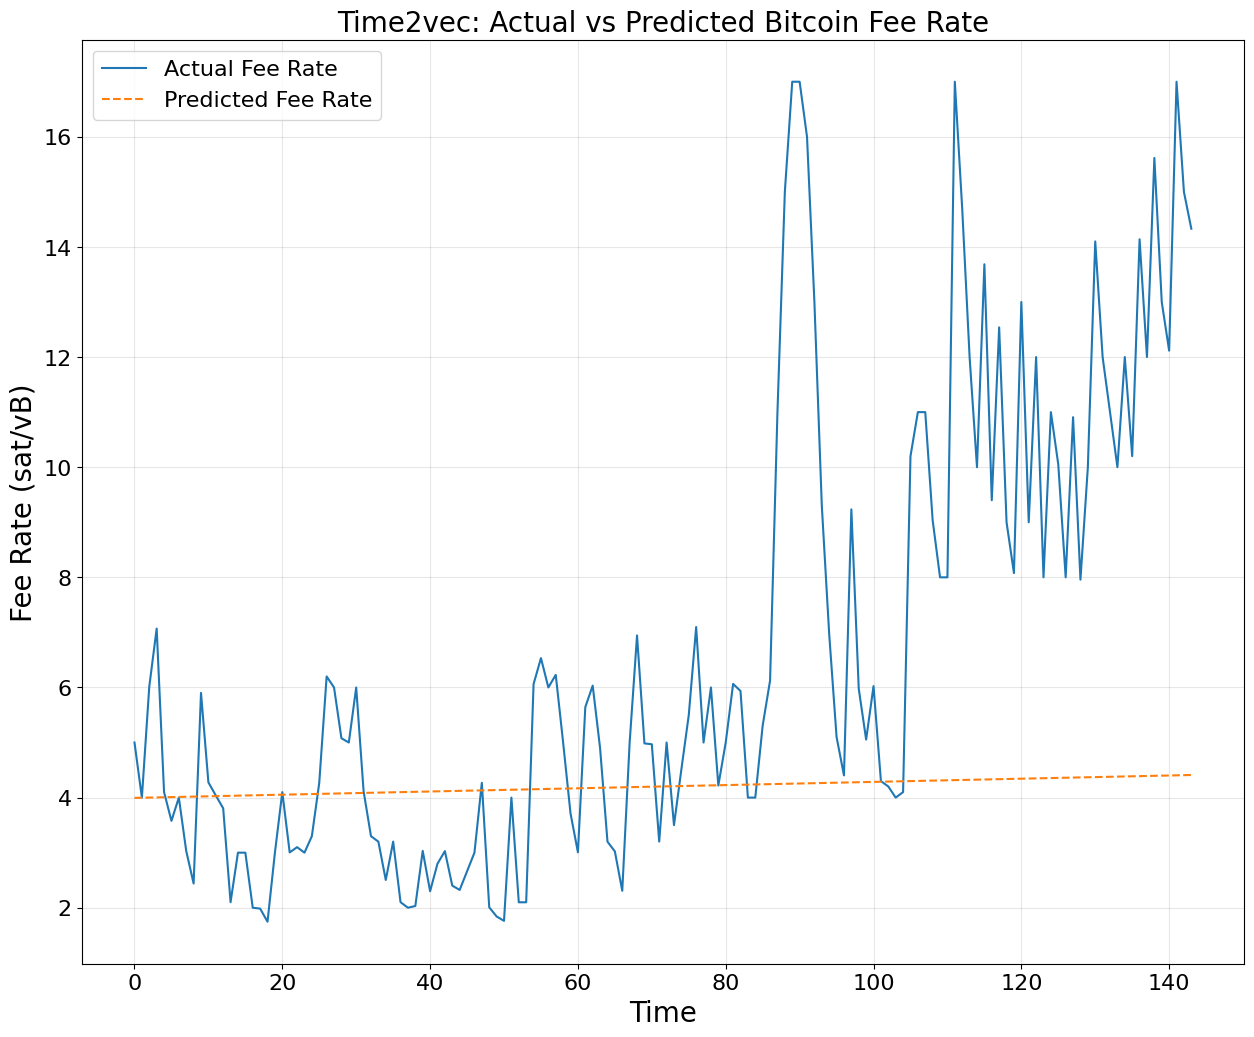

In [4]:
# After getting study, predictions, cv_results from main execution
sf = pd.read_csv('test.csv')
actual_values = sf['block_median_fee_rate']
predicted_values = predictions['predicted_fee_rate']

# Initialize predictor for metrics
predictor = BitcoinFeePredictor()
metrics = predictor.calculate_metrics(actual_values.values, predicted_values.values)

# Print metrics
print("Performance Metrics:")
print(f"Mean Absolute Error (MAE): {metrics.mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {metrics.rmse:.4f}")
print(f"Theil's U Statistic: {metrics.theil_u:.4f}")

# Create plot with your preferred style
plt.figure(figsize=(15, 12))

# Plot actual values
plt.plot(actual_values.index, actual_values, 
         label='Actual Fee Rate')

# Plot predicted values
plt.plot(actual_values.index, predicted_values, 
         label='Predicted Fee Rate', linestyle='--')

# Add title and labels
plt.title('Time2vec: Actual vs Predicted Bitcoin Fee Rate', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Fee Rate (sat/vB)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add legend and grid
plt.legend(fontsize=16)
plt.grid(alpha=0.3)
plt.savefig('time2vec_test.png',dpi=600)

plt.show()